In [14]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
from glob import glob
import os,sys
import itertools
from copy import deepcopy

In [17]:
name = "900steps_100fits"
work_path = "/data/user/tvaneede/GlobalFit/reco_processing/bdt/training/optimize_training/optimize_cuts/output/"
folder_path = f"{work_path}/{name}"

In [45]:
import os
import pandas as pd

# Path to your folders
folder_path = "/data/user/tvaneede/GlobalFit/reco_processing/bdt/training/optimize_training/optimize_cuts/output/900steps_100fits/"

# Get all folders in that directory
folders = [f for f in os.listdir(folder_path) if os.path.isdir(os.path.join(folder_path, f))]

rows = []
for f in folders:
    # Split mcd, flux, feature
    try: 
        mcd_part, rest = f.split("_flux-", 1)
        mcd_part = mcd_part.split("-")[-1]
    except ValueError: mcd_part, rest = f, ""
    
    try: flux_part, feat_part = rest.split("_feat-", 1)
    except ValueError: flux_part, feat_part = rest, ""
    
    rows.append({
        "name": f,
        "model_configs_name": mcd_part,
        "flux_model_name": flux_part,
        "features_list_name": feat_part
    })

    df = pd.DataFrame(rows)
df = df.sort_values("name").reset_index(drop=True)
df["model_path"] = df["name"].apply(lambda n: os.path.join(work_path, name, n))

In [46]:
# the flux doesnt matter, so I only do HESE
flux_mask = df["flux_model_name"] == "hese"
df = df[flux_mask]

In [47]:
def obtain_optimal_bdt_score( model_path ):
    model_name = model_path.split("/")[-1]
    df = pd.read_parquet(f"{model_path}/optimization.parquet")
    df["variance_ratio_sum"]  = df["variance_nue_ratio"] + df["variance_nutau_ratio"]
    optimal_row = df.loc[df["variance_ratio_sum"].idxmin()].copy()
    optimal_row["model_name"] = model_name
    return optimal_row

In [48]:
optimal_df = df.loc[df["model_path"].notna(), "model_path"].apply(obtain_optimal_bdt_score).apply(pd.Series)
df = df.join(optimal_df)

Lets see what leads to better BDTs, using flavor or simple topology. Slight slight improvement when using simple topology


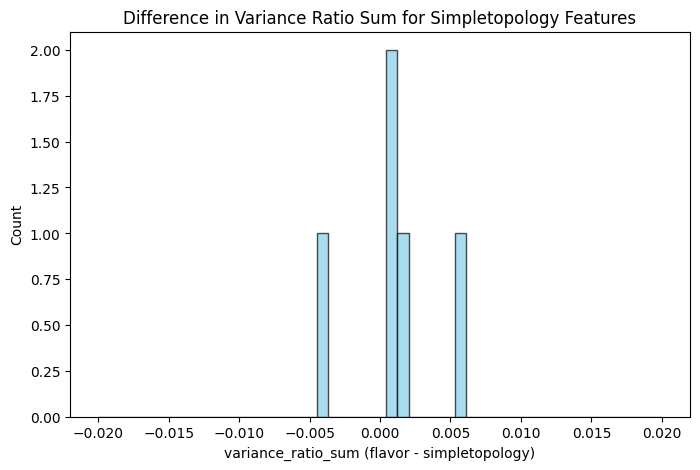

In [66]:
# Filter rows where features_list_name is in simpletopology features
simpletopology_features = df.loc[df["model_configs_name"] == "simpletopology", "features_list_name"].unique()
df_simpletopo = df[df["features_list_name"].isin(simpletopology_features)]

# Split into old and new
df_flavor = df_simpletopo[df_simpletopo["model_configs_name"] == "flavor"]
df_simple = df_simpletopo[df_simpletopo["model_configs_name"] == "simpletopology"]

# Merge on features_list_name to align rows
df_merged = df_flavor.merge(
    df_simple,
    on="features_list_name",
    suffixes=("_flavor", "_simpletopology")
)

# Compute difference: old - new
variance_diff = df_merged["variance_ratio_sum_flavor"] - df_merged["variance_ratio_sum_simpletopology"]

# Plot histogram
bins = np.linspace(-0.02, 0.02, 50)
plt.figure(figsize=(8,5))
plt.hist(variance_diff, bins=bins, alpha=0.7, color="skyblue", edgecolor="black")
plt.xlabel("variance_ratio_sum (flavor - simpletopology)")
plt.ylabel("Count")
plt.title("Difference in Variance Ratio Sum for Simpletopology Features")
plt.show()


Training with flavor works best. Now lets look at the features

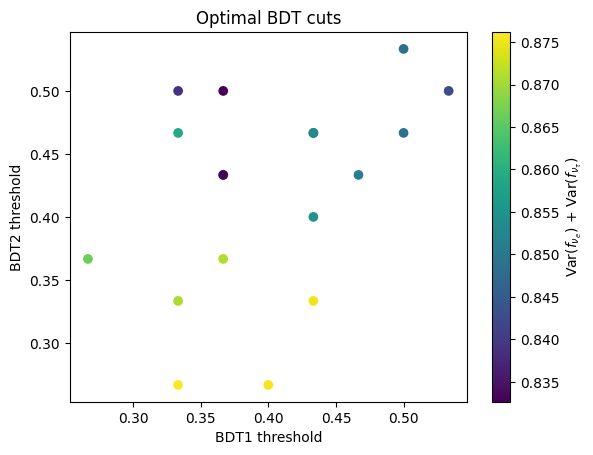

In [68]:
def scatter_optimal_bdt(df_subset):
    plt.figure()
    sc = plt.scatter(df_subset["cut_bdt1"], df_subset["cut_bdt2"], c=df_subset["variance_ratio_sum"])
    plt.xlabel("BDT1 threshold")
    plt.ylabel("BDT2 threshold")
    plt.title("Optimal BDT cuts")
    plt.colorbar(sc, label=r"Var($f_{\nu_e}$) + Var($f_{\nu_{\tau}}$)")
    plt.show()

flux_mask = df["flux_model_name"] == "hese"
model_mask = df["model_configs_name"] != "truetopology"

scatter_optimal_bdt(df[flux_mask & model_mask])


In [70]:
df_sorted = df[flux_mask & model_mask].sort_values("variance_ratio_sum", ascending=True)
df_sorted[["features_list_name","model_configs_name","cut_bdt1","cut_bdt2","variance_ratio_sum",'n_cascade', 'n_double','n_track']]

,features_list_name,model_configs_name,cut_bdt1,cut_bdt2,variance_ratio_sum,n_cascade,n_double,n_track
33,11features_plus_rloglmilli_econf_evtgen,simpletopology,0.366667,0.500000,0.832659,235700.0,52827.0,81920.0
26,11features_plus_rloglmilli_econf_evtgen,flavor,0.366667,0.433333,0.833246,235348.0,56601.0,78498.0
27,13features,flavor,0.333333,0.500000,0.838998,235187.0,54300.0,80960.0
32,11features_ibr_plus_rloglmilli_econf_evtgen,simpletopology,0.533333,0.500000,0.842834,238803.0,52191.0,79453.0
20,11features_ibr_plus_rloglmilli_econf_evtgen,flavor,0.433333,0.466667,0.844398,236796.0,54742.0,78909.0
19,11features_ibr_idc_plus_rloglmilli_econf_evtgen,flavor,0.500000,0.533333,0.848750,237257.0,50859.0,82331.0
25,11features_plus_rloglmilli,flavor,0.500000,0.466667,0.848842,236969.0,56208.0,77270.0
21,11features_plus_econf,flavor,0.466667,0.433333,0.851067,236146.0,55689.0,78612.0
31,11features_ibr_idc_plus_rloglmilli_econf_evtgen,simpletopology,0.433333,0.466667,0.853128,237524.0,54203.0,78720.0
22,11features_plus_evtgen,flavor,0.433333,0.400000,0.854953,236388.0,59403.0,74656.0


In [72]:
df_sorted = df[flux_mask & model_mask].sort_values("variance_ratio_sum", ascending=True)
cols = [
    'features_list_name','model_configs_name',
    'rate_tracks_NuE', 'rate_tracks_NuMu', 'rate_tracks_NuTau',
    'rate_tracks_conv', 
    'rate_cascades_NuE', 'rate_cascades_NuMu', 'rate_cascades_NuTau',
    'rate_cascades_conv',
    'rate_doubles_NuE', 'rate_doubles_NuMu', 'rate_doubles_NuTau',
    'rate_doubles_conv'
]

out = df_sorted[cols].rename(
    columns=lambda c: c
        .replace('rate_tracks_', '')
        .replace('rate_cascades_', '')
        .replace('rate_doubles_', '')
)

out = out.apply(
    lambda s: s.round(2) if s.dtype.kind in "fc" else s
)

out

,features_list_name,model_configs_name,NuE,NuMu,NuTau,conv,NuE,NuMu,NuTau,conv,NuE,NuMu,NuTau,conv
33,11features_plus_rloglmilli_econf_evtgen,simpletopology,0.17,14.12,1.84,10.60,57.99,6.78,28.23,14.98,0.08,0.21,4.28,0.10
26,11features_plus_rloglmilli_econf_evtgen,flavor,0.15,14.06,1.81,10.57,58.00,6.75,28.19,15.00,0.09,0.30,4.34,0.11
27,13features,flavor,0.18,13.84,1.82,9.93,57.94,7.01,28.19,15.63,0.12,0.26,4.34,0.12
32,11features_ibr_plus_rloglmilli_econf_evtgen,simpletopology,0.06,13.16,1.58,9.13,58.13,7.74,28.63,16.42,0.05,0.21,4.14,0.13
20,11features_ibr_plus_rloglmilli_econf_evtgen,flavor,0.09,13.41,1.68,9.47,58.07,7.45,28.41,16.08,0.08,0.25,4.26,0.14
19,11features_ibr_idc_plus_rloglmilli_econf_evtgen,flavor,0.08,13.36,1.72,9.45,58.11,7.56,28.44,16.11,0.05,0.19,4.19,0.12
25,11features_plus_rloglmilli,flavor,0.13,13.53,1.70,9.62,58.04,7.30,28.41,15.94,0.08,0.28,4.24,0.12
21,11features_plus_econf,flavor,0.17,13.78,1.76,10.10,57.98,7.01,28.34,15.44,0.09,0.32,4.25,0.14
31,11features_ibr_idc_plus_rloglmilli_econf_evtgen,simpletopology,0.07,13.41,1.70,9.64,58.11,7.45,28.42,15.92,0.06,0.25,4.23,0.13
22,11features_plus_evtgen,flavor,0.16,13.42,1.72,9.53,57.99,7.29,28.36,16.01,0.09,0.40,4.27,0.14
